# Conduct time varying sensitivity analysis for T2 and LST

## Setting up

### Import packages here

In [1]:
import pickle
from xarray import open_dataset
from numpy import (sqrt, append, isnan, datetime64, arange, linspace, zeros, sum, array, dot, stack
    ,maximum, minimum, fmax, fmin, ceil, sign, quantile, mod)
from sklearn.decomposition import PCA
from sklearn.neighbors import KDTree

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import colorbar, colors
import matplotlib.patches as mpatches
from multiprocessing import Queue, Process

# some parameters
plt.rcParams.update({'font.size': 14})

In [2]:
from wrf_fvcom.variables import (
    WRF_PBL_SFCLAY, WRF_WaterZ0, WRF_MP, WRF_RA, WRF_LM,
    FVCOM_Prandtl, FVCOM_SWRadiationAbsorption,
    FVCOM_VerticalMixing, FVCOM_WindStress,
)
from wrf_fvcom.perturb import (
    transform_perturbation_matrix,
)
from surrogate.utils import surrogate_model_predict
from surrogate.gsa import compute_sensitivities, plot_sens

### Set the variables to analyze and get list of filenames

In [3]:
# time start and end 
ts = datetime64('2018-06-01')
te = datetime64('2018-09-01')

# choose variables want to analyze..
variables = [WRF_PBL_SFCLAY,
             WRF_MP, 
             WRF_RA,
             WRF_WaterZ0,
             WRF_LM,
             FVCOM_VerticalMixing,
             FVCOM_WindStress,
             FVCOM_Prandtl,
             FVCOM_SWRadiationAbsorption,
            ]

# get the variable names as a list
variable_names = [variable.name for variable in variables]

# test set does not have WRF_LM inside
variable_names_test = [variable.name for variable in variables if variable is not WRF_LM]
no_name_I = [4]
test_run_I = [0,2,4,5,8]

In [4]:
#filenames
train_parameters_file = '../output/perturbation_matrix_9variables_korobov18.nc'
test_parameters_file = '../output/perturbation_matrix_8variables_korobov19.nc'
train_output_filename = '../output/wfv_global_daily_temperature_training_set.pkl'
test_output_filename = '../output/wfv_global_daily_temperature_test_set.pkl'

#surrogate output filename
LST_surrogate_filename = '../output/LST_klsurrogate_models.pkl'
T2_surrogate_filename = '../output/T2_klsurrogate_models.pkl'

# fvcom grid
# directories
proj_dir = '/lus/grand/projects/COMPASS-GLM/WRF+FVCOM_Sensitivity/'
fvcom_grid_file = proj_dir + 'fvcom_grid.nc' 

## Load inputs 

### parameter info

In [5]:
# Get parameter training range and ensemble
params = open_dataset(train_parameters_file)
pnames = params.sel(variable=variable_names).variable.values
ptrain = params.sel(variable=variable_names).perturbation_matrix

# transform the input matrix
variable_matrix_train = transform_perturbation_matrix(ptrain)

In [6]:
# Get parameter test range and ensemble
params_t = open_dataset(test_parameters_file)
pnames_t = params_t.sel(variable=variable_names_test).isel(run=test_run_I).variable.values

# combining both sets of runs
ptest_t = params_t.sel(variable=variable_names_test).isel(run=test_run_I).perturbation_matrix
#
# transform into same variable number as train set and put value of 1 for Land Model
ptest = ptrain.isel(run=test_run_I)
ptest[:,[idx for idx, var_name in enumerate(variable_names) if idx not in no_name_I]] = ptest_t.values
ptest[:,no_name_I] = 1

# transform the input matrix
variable_matrix_test_t = transform_perturbation_matrix(ptest)
# transform into same scheme number as train set and put value of 0 where doesn't exist
variable_matrix_test = variable_matrix_train.isel(run=test_run_I)
scheme_names = variable_matrix_test['scheme'].values
no_scheme_I = [idx for idx, scheme_name in enumerate(scheme_names)
               if scheme_name not in variable_matrix_test_t['scheme'].values]
variable_matrix_test[:,[idx for idx, scheme_name in enumerate(scheme_names) if idx not in no_scheme_I]] = \
    variable_matrix_test_t.values
variable_matrix_test[:,no_scheme_I] = 0

### data info

In [7]:
#load the training data
with open(train_output_filename, 'rb') as fp:
    train_dict = pickle.load(fp)
    print('Done loading training data from binary file')
    
with open(test_output_filename, 'rb') as fp:
    test_dict = pickle.load(fp)
    print('Done loading test data from binary file')

Done loading training data from binary file
Done loading test data from binary file


In [8]:
# Get and check train sizes
nens = len(train_dict['runs'])
ntime = train_dict['LST'][0][0].shape[0]
ntime_, ngrid = train_dict['LST'][0][1].shape
nens_ = len(train_dict['LST'])
nens__, ndim = variable_matrix_train.shape
ntime__, nlat, nlon = train_dict['T2'][0][1].shape

# sanity check
assert(ntime==ntime_)
assert(nens==nens_)
assert(nens==nens__)

# Print useful info
print('Training set info:')
print(f'Ensembles size : {nens}')
print(f'Parameter dim : {ndim}')
print(f'FVCOM Timeseries size : {ntime}')
print(f'WRF Timeseries size : {ntime__}')
print(f'Spatial size FVCOM: {ngrid}')
print(f'Spatial size WRF: {nlat},{nlon}')

nens_train = nens

Training set info:
Ensembles size : 18
Parameter dim : 20
FVCOM Timeseries size : 112
WRF Timeseries size : 111
Spatial size FVCOM: 35749
Spatial size WRF: 484,543


In [9]:
# Get and check test sizes
nens = len(test_dict['runs'])
ntime = test_dict['LST'][0][0].shape[0]
ntime_, ngrid = test_dict['LST'][0][1].shape
nens_ = len(test_dict['LST'])
nens__, ndim = variable_matrix_test.shape
ntime__, nlat, nlon = test_dict['T2'][0][1].shape

# sanity check
assert(ntime==ntime_)
assert(nens==nens_)
assert(nens==nens__)

# Print useful info
print('Test set info:')
print(f'Ensembles size : {nens}')
print(f'Parameter dim : {ndim}')
print(f'FVCOM Timeseries size : {ntime}')
print(f'WRF Timeseries size : {ntime__}')
print(f'Spatial size FVCOM: {ngrid}')
print(f'Spatial size WRF: {nlat},{nlon}')

nens_test = nens

Test set info:
Ensembles size : 5
Parameter dim : 20
FVCOM Timeseries size : 112
WRF Timeseries size : 111
Spatial size FVCOM: 35749
Spatial size WRF: 484,543


### forming lake masks

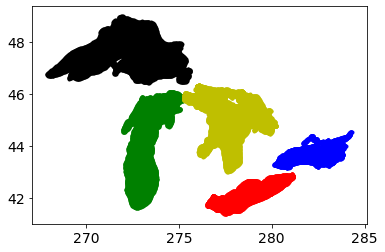

In [10]:
# FVCOM mask
lon = train_dict['LST'][0][1].lon.values
lat = train_dict['LST'][0][1].lat.values
superior = (lat > 46.2) & (lon < 275.9)
plt.plot(lon[superior],lat[superior],'k.')
erie = (lat < 43) & (lon > 275)
plt.plot(lon[erie],lat[erie],'r.')
ontario = (lat > 43) & (lat < 44.55) & (lon > 280)
plt.plot(lon[ontario],lat[ontario],'b.')
michigan = (lat < 46.25) & (lon < 275.25)
plt.plot(lon[michigan],lat[michigan],'g.')
huron = ~((michigan) | (superior) | (erie) | (ontario)) & (lon < 282)
plt.plot(lon[huron],lat[huron],'y.')
plt.show()

lake_dict = {}
lake_dict['LST'] = {'Superior': superior,
             'Huron': huron,
             'Michigan': michigan,
             'Ontario': ontario,
             'Erie': erie,
            }

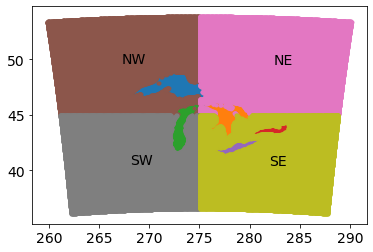

In [11]:
# WRF mask
wrflon = train_dict['T2'][0][1].XLONG.values + 360
wrflat = train_dict['T2'][0][1].XLAT.values
wrf_points = stack((wrflon.flatten(),wrflat.flatten())).transpose()

var = 'T2m'
lake_dict[var] = {'Superior': superior,
             'Huron': huron,
             'Michigan': michigan,
             'Ontario': ontario,
             'Erie': erie,
            }
for ll,lake in enumerate(lake_dict[var]):
    lakeI = lake_dict[var][lake]
    kdt = KDTree(stack((lon[lakeI],lat[lakeI])).transpose())
    d,k = kdt.query(wrf_points)
    ii = (d < 5/111).squeeze()
    plt.plot(lon[lakeI],lat[lakeI],'k.')
    plt.plot(wrf_points[ii,0],wrf_points[ii,1],'.')
    lake_dict[var][lake] = ii
    if ll == 0:
        all_lakes = ii
    else:
        all_lakes = ii | all_lakes
    
land = ~all_lakes

land_dict = {'NW': (wrf_points[:,0] <= 275) & (wrf_points[:,1] > 45),
             'NE': (wrf_points[:,0] > 275) & (wrf_points[:,1] > 45),
             'SW': (wrf_points[:,0] <= 275) & (wrf_points[:,1] <= 45),
             'SE': (wrf_points[:,0] > 275) & (wrf_points[:,1] <= 45),
            }
for area in land_dict:
    landI = (land) & (land_dict[area])
    plt.plot(wrf_points[landI,0],wrf_points[landI,1],'.')
    plt.text(wrf_points[landI,0].mean(),wrf_points[landI,1].mean(),area)

In [12]:
# construct the training data into right dimensions
model_data = {}
model_data['LST'] = {}
ntime2 = {}
for rdx, run in enumerate(train_dict['LST']):
    tdx = (run[0] >= ts) & (run[0] < te)
    ntime2['LST'] = tdx.sum()
    value_temp = run[1].isel(time=tdx).values.reshape(1,-1)
    if rdx == 0:
        model_data['LST']['train'] = value_temp
    else:
        model_data['LST']['train'] = append(model_data['LST']['train'],value_temp,axis=0)
display(model_data['LST']['train'].shape)
        
# construct the training data into right dimensions
for rdx, run in enumerate(test_dict['LST']):
    tdx = (run[0] >= ts) & (run[0] < te)
    ntime2_ = tdx.sum()
    value_temp = run[1].isel(time=tdx).values.reshape(1,-1)
    if rdx == 0:
        model_data['LST']['test'] = value_temp
    else:
        model_data['LST']['test'] = append(model_data['LST']['test'],value_temp,axis=0)
assert(ntime2['LST'] == ntime2_)

display(model_data['LST']['test'].shape)

(18, 3288908)

(5, 3288908)

In [13]:
# construct the training data into right dimensions
model_data['T2m'] = {} 
for rdx, run in enumerate(train_dict['T2']):
    tdx = (run[0] >= ts) & (run[0] < te)
    ntime2['T2m'] = tdx.sum()
    value_temp = run[1].isel(time=tdx).values.reshape(1,-1)
    if rdx == 0:
        model_data['T2m']['train'] = value_temp
    else:
        model_data['T2m']['train'] = append(model_data['T2m']['train'],value_temp,axis=0)
display(model_data['T2m']['train'].shape)
        
# construct the training data into right dimensions
for rdx, run in enumerate(test_dict['T2']):
    tdx = (run[0] >= ts) & (run[0] < te)
    ntime2_ = tdx.sum()
    value_temp = run[1].isel(time=tdx).values.reshape(1,-1)
    if rdx == 0:
        model_data['T2m']['test'] = value_temp
    else:
        model_data['T2m']['test'] = append(model_data['T2m']['test'],value_temp,axis=0)
assert(ntime2['T2m'] == ntime2_)

display(model_data['T2m']['test'].shape)

(18, 23915892)

(5, 23915892)

### surrogate models

In [14]:
# load the surrogate models
kl_surrogate = {}
with open(LST_surrogate_filename, 'rb') as fp:
    kl_surrogate['LST'] = pickle.load(fp)
    print('Done loading LST surrogate from binary file')
    
with open(T2_surrogate_filename, 'rb') as fpp:
    kl_surrogate['T2m'] = pickle.load(fpp)
    print('Done loading T2 surrogate from binary file')
    
# surrogate input settings
# using hot_enconding or not
hot_encode = True
# setup training and test inputs based on onehotencoding or not
x_vals = {}
if hot_encode:
    x_vals['train'] = variable_matrix_train
    x_vals['test'] = variable_matrix_test
else:
    x_vals['train'] = ptrain
    x_vals['test'] = ptest

Done loading LST surrogate from binary file
Done loading T2 surrogate from binary file


## Decompose the time series

In [15]:
# some variables for surrogate
var_explained = len(variables) #for PCA

# randomization
random_seeds = range(111,999+111,111)
#seed = 666 # val_loss = 0.71 , BO gives ??
#seed = 111 # val_loss = 0.67,  BO gives BO1 parameters
#seed = 99 # val_loss = 0.73 , BO gives BO1 except COARE, GOTM k-eps
#seed = 222 # val_loss = 0.66, BO gives BO1 except COARE, GOTM k-eps
#seed = None

In [16]:
pca_data = {}
for var in model_data:
    trainY = model_data[var]['train']
    testY = model_data[var]['test']
    # Decompose the spatiotemporal series using PCA/KL
    pca_obj = PCA(n_components=var_explained, 
                  random_state=random_seeds[0], 
                  whiten=True)
    pca_obj.fit(trainY)

    print(pca_obj.explained_variance_ratio_)
    print(pca_obj.explained_variance_ratio_.sum())
    print(f'number of eigenmodes is {pca_obj.n_components_}')
    
    pca_data[var] = {}
    # get the outputs from the PCA
    pca_data[var]['klxi_train'] = pca_obj.transform(trainY)
    pca_data[var]['klxi_test']  = pca_obj.transform(testY)
    pca_data[var]['eigenratio'] = pca_obj.explained_variance_ratio_
    pca_data[var]['neig'] = pca_obj.n_components_
    pca_data[var]['eigenvalues'] = pca_obj.explained_variance_
    pca_data[var]['eigenmodes'] = pca_obj.components_
    pca_data[var]['mean_vector'] = pca_obj.mean_

[0.59524146 0.10616204 0.04990378 0.04276877 0.03184092 0.0306296
 0.02111236 0.0180193  0.01771278]
0.9133910082750212
number of eigenmodes is 9
[0.6299013  0.09171014 0.06312568 0.03856222 0.03501988 0.02503296
 0.01906686 0.01674813 0.01424874]
0.9334159
number of eigenmodes is 9


## Temporal varying Sensitivities

### Get kl_dicts for spatial average across each lake and land area

In [17]:
kl_dict = {}
for var in ['LST','T2m']:

    # reshape the mean vector and eigenmodes so we can manipulate by dimension
    mean_vector_reshape = pca_data[var]['mean_vector'].reshape(ntime2[var],-1)
    eigenmodes_reshape = pca_data[var]['eigenmodes'].reshape(pca_data[var]['neig'],ntime2[var],-1)

    # use WRF mask to make kl_dict for lake and land..
    kl_dict[var] = {}
    for lake in lake_dict[var]:
        kl_dict[var][lake] = {'eigenmodes': eigenmodes_reshape[:,:,lake_dict[var][lake]].mean(axis=2),
               'eigenvalues': pca_data[var]['eigenvalues'],
               'mean_vector': mean_vector_reshape[:,lake_dict[var][lake]].mean(axis=1), 
              }

# add land to T2m
for area in land_dict:
        kl_dict[var][area] = {'eigenmodes': eigenmodes_reshape[:,:,land_dict[area]].mean(axis=2),
               'eigenvalues': pca_data[var]['eigenvalues'],
               'mean_vector': mean_vector_reshape[:,land_dict[area]].mean(axis=1), 
              }

### GSA for LST and T2m in time

In [18]:
# assign and execute the sensitivity computation in parallel
def add_helper(queue, pn, a1, a2, a3, a4): # the func called in child processes
    sens_sobol, srange = compute_sensitivities(a1, a2, sample_size=a3, kl_dict=a4)
    queue.put([sens_sobol, srange, pn])

sample_size = 2**8

# collect all uncertainty and sensitivity data for each lake
SENSD_temporal = {}

In [19]:
for var in ['LST','T2m']:
    print(var)
    SENSD_temporal[var] = {}
    for lake in lake_dict[var]:
        print(lake)
        q = Queue()
        processes = []
        proc_num = 0
        sens_info = {}
        tvs = {} 
        for sur in kl_surrogate[var]['NN']:
            p = Process(target=add_helper, args=(q, proc_num, sur, x_vals['train'], sample_size, kl_dict[var][lake]))
            processes.append(p)
            p.start()
            proc_num += 1
        
        rets = [None] * proc_num
        for p in processes:
            ret = q.get() 
            print(f'proc_num = {ret[-1]}')
            rets[ret[-1]] = ret[0:2] # add in the right order based on proc_number
        for p in processes:
            p.join()
            
        # collect into SENS_temporal dict
        for ss, ret in enumerate(rets):
            sens_sobol, srange = ret
            if ss == 0:
                gsa_range = srange
            else:
                gsa_range = append(gsa_range,srange,axis=0)

            for sens_label in ['main','total']:
                if ss == 0:
                    tvs[sens_label] = sens_sobol[sens_label]
                else:
                    tvs[sens_label] += sens_sobol[sens_label]
                    
        for sens_label in ['main','total']:           
            tvs[sens_label] /= len(kl_surrogate[var]['NN'])
            
        SENSD_temporal[var][lake] = {'gsa_range': gsa_range, 'tvs': tvs}

LST
Superior
Initializing SOBOL
Initializing SOBOL
Sampling SOBOLInitializing SOBOL



Initializing SOBOLSampling SOBOLSampling SOBOLInitializing SOBOL



Initializing SOBOLSampling SOBOLSampling SOBOLInitializing SOBOL

Initializing SOBOLSampling SOBOLInitializing SOBOL


Sampling SOBOLSampling SOBOL
Sampling SOBOL

proc_num = 3
proc_num = 4
proc_num = 0
proc_num = 5
proc_num = 1
proc_num = 2
proc_num = 6
proc_num = 8
proc_num = 7
Huron
Initializing SOBOL
Initializing SOBOL
Sampling SOBOLInitializing SOBOL

Sampling SOBOL
Initializing SOBOL
Sampling SOBOLInitializing SOBOL

Sampling SOBOLInitializing SOBOL
Sampling SOBOLInitializing SOBOL


Initializing SOBOL
Sampling SOBOL
Sampling SOBOLSampling SOBOL

Initializing SOBOL
Sampling SOBOL
proc_num = 1
proc_num = 2
proc_num = 7
proc_num = 3
proc_num = 6
proc_num = 0
proc_num = 8
proc_num = 5
proc_num = 4
Michigan
Initializing SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOLSampling SOBOL

Initi

In [20]:
# collect T2m uncertainty and sensitivity data for each land area quarter
var ='T2m'
for area in land_dict:
    print(area)
    q = Queue()
    processes = []
    proc_num = 0 
    sens_info = {}
    tvs = {} 
    for ss, sur in enumerate(kl_surrogate[var]['NN']):
        sens_sobol, srange = compute_sensitivities(
            sur, x_vals['train'], sample_size=sample_size, kl_dict=kl_dict[var][area]
        )
        
        # collect into SENSD_temporal dict
        if ss == 0:
            gsa_range = srange
        else:
            gsa_range = append(gsa_range,srange,axis=0)

        for sens_label in ['main','total']:
            if ss == 0:
                tvs[sens_label] = sens_sobol[sens_label]
            else:
                tvs[sens_label] += sens_sobol[sens_label]

    for sens_label in ['main','total']:           
        tvs[sens_label] /= len(kl_surrogate[var]['NN'])

    SENSD_temporal[var][area] = {'gsa_range': gsa_range, 'tvs': tvs}

NW
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
NE
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
SW
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
SE
Initializing SOBOL
Sampling SOBOL
Initializing SOBOL
Sampling SOBOL
In

In [29]:
# compute uncertainty first as can take some time
for var in ['LST','T2m']: # 
    print(var)
    for lake in SENSD_temporal[var]:
        SENSD_temporal[var][lake]['uncertainty'] = (
            quantile(SENSD_temporal[var][lake]['gsa_range'],0.95,axis=0) -
            quantile(SENSD_temporal[var][lake]['gsa_range'],0.05,axis=0)
                      )
        print(lake)
        print(f"mean = {SENSD_temporal[var][lake]['uncertainty'].mean()} +/- {SENSD_temporal[var][lake]['uncertainty'].std()}")

LST
Superior
mean = 1.7738565475598078 +/- 0.5208196925458783
Huron
mean = 1.561697702800764 +/- 0.2700629733020996
Michigan
mean = 1.5542415690542983 +/- 0.30067893149353564
Ontario
mean = 1.5145584762483437 +/- 0.31328294198902246
Erie
mean = 1.696128813874272 +/- 0.20323290942166872
T2m
Superior
mean = 2.390449794826867 +/- 0.5251551850181622
Huron
mean = 2.1298786420874607 +/- 0.41568716167518166
Michigan
mean = 2.0173907067276935 +/- 0.3733933590190606
Ontario
mean = 1.9415126985694833 +/- 0.4801063344831772
Erie
mean = 1.7728648321062894 +/- 0.5167174109206478
NW
mean = 1.7950108040526866 +/- 0.3965015710765567
NE
mean = 1.7620459592624322 +/- 0.45464655212215416
SW
mean = 1.5956280026368244 +/- 0.4110180819261147
SE
mean = 1.3661051877256039 +/- 0.3433530414630264


## Plotting temporal varabilities

### Plotting sensitivities and uncertainties together

In [22]:
pname_paper = ['PBL+SFC', 'MP', 'LW+SW Rad', 'z0$_w$', 'LSM', 
               'VM', 'WS', 'Pr$_t$', '$R$']
# only choose top 6
pnames_sel = array(pname_paper)[[0,1,2,3,4,6]]
#pnames_sel = array(pname_paper)[[0,2,4,6]]
print(pnames_sel)

['PBL+SFC' 'MP' 'LW+SW Rad' 'z0$_w$' 'LSM' 'WS']


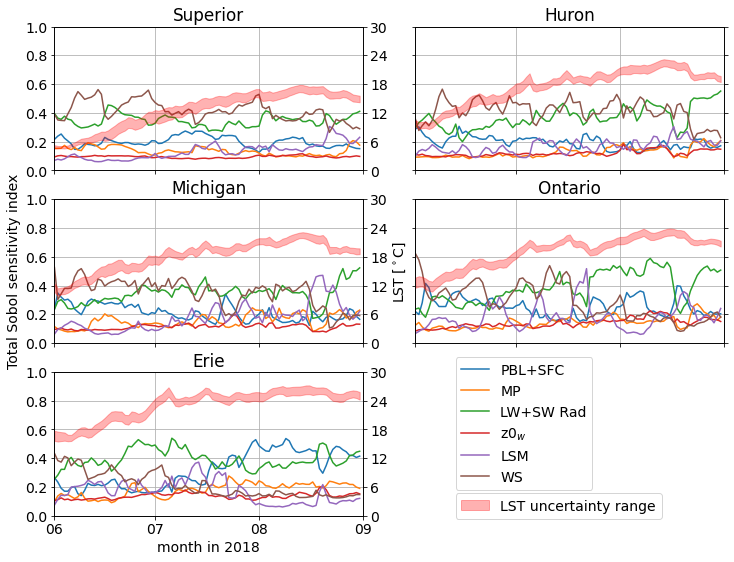

In [23]:
# For LST
var = 'LST'
time = train_dict[var][0][0]
tdx = (time >= ts) & (time < te)
time = time[tdx]

fig, axs = plt.subplots(int(ceil(len(SENSD_temporal[var])/2)), 2, 
                        sharey=True, sharex=True, figsize=(12,9))
adx = 0
for ldx, lake in enumerate(SENSD_temporal[var]):
    #if lake in ['Huron','Ontario']:
    #    continue
    ax = axs.flat[adx]
    for pname in pnames_sel:
        pdx = pname_paper.index(pname)
        ax.plot(time,SENSD_temporal[var][lake]['tvs']['total'][:,pdx],label=pname)

    ax.set_title(f'{lake}')
    ax.set_ylim([0,1.0])
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m'))
    ax.set_xlim([ts,te])
    ax.grid()
    
    ax2 = ax.twinx()
    ax2.fill_between(time,
                     quantile(SENSD_temporal[var][lake]['gsa_range'],0.05,axis=0),
                     quantile(SENSD_temporal[var][lake]['gsa_range'],0.95,axis=0),
                     color='r',alpha=0.3,label='LST uncertainty range')
    ax2.set_ylim([0,30])
    ax2.set_yticks(range(0,36,6))
    
    if mod(adx,2) == 1:
        ax2.set_yticklabels('')
    
    if adx == int(len(SENSD_temporal[var])/2):
        ax.set_ylabel('Total Sobol sensitivity index')
        ax2.set_ylabel('LST [$^\circ$C]')
        
    if adx == len(SENSD_temporal[var])-1:
        ax.legend(loc=(1.3,0.18))
        ax2.legend(loc=(1.3,-0.02))
    
    if adx > len(SENSD_temporal[var])-2:
        ax.set_xlabel('month in 2018')
    
    adx += 1

fig.delaxes(axs.flat[-1])
#axs.flat[-2].legend() #loc=(1.1,0))
#ax2.legend(loc=(1.1,2))
    
#plt.suptitle('Temporal variation in LST sensitivity')

plt.subplots_adjust(wspace=0.17)
plt.savefig('../figures/LST_temporal_dist',dpi=600,bbox_inches='tight')
plt.show()

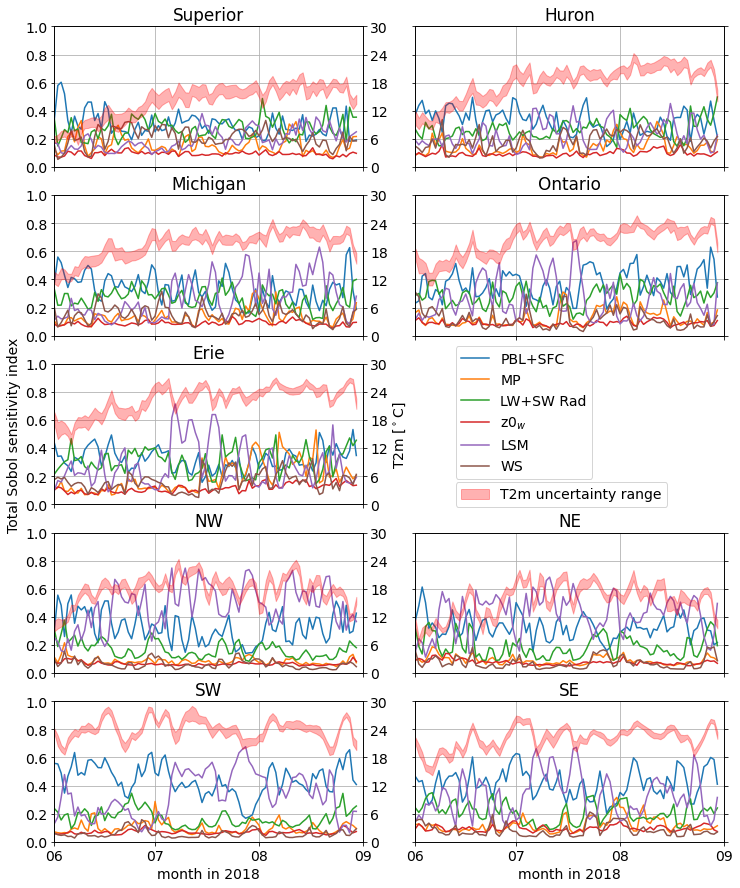

In [24]:
# For T2m
var = 'T2m'
time = train_dict['T2'][0][0]
tdx = (time >= ts) & (time < te)
time = time[tdx]

fig, axs = plt.subplots(int(ceil(len(SENSD_temporal[var])/2)), 2, 
                        sharey=True, sharex=True, figsize=(12,15))
adx = 0
for ldx, lake in enumerate(SENSD_temporal[var]):
    if lake == 'NW':
        adx += 1
    ax = axs.flat[adx]
    for pname in pnames_sel:
        pdx = pname_paper.index(pname)
        ax.plot(time,SENSD_temporal[var][lake]['tvs']['total'][:,pdx],label=pname)

    ax.set_title(f'{lake}')
    ax.set_ylim([0,1.0])
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m'))
    ax.set_xlim([ts,te])
    ax.grid()
    
    ax2 = ax.twinx()
    ax2.fill_between(time,
                     quantile(SENSD_temporal[var][lake]['gsa_range'],0.05,axis=0),
                     quantile(SENSD_temporal[var][lake]['gsa_range'],0.95,axis=0),
                     color='r',alpha=0.3,label='T2m uncertainty range')
    ax2.set_ylim([0,30])
    ax2.set_yticks(range(0,36,6))
    
    if mod(adx,2) == 1:
        ax2.set_yticklabels('')
    
    if adx == int(len(SENSD_temporal[var])/2):
        ax.set_ylabel('Total Sobol sensitivity index')
        ax2.set_ylabel('T2m [$^\circ$C]')
        
    if adx == 4:
        ax.legend(loc=(1.3,0.18))
        ax2.legend(loc=(1.3,-0.02))
    
    if adx > len(SENSD_temporal[var])-2:
        ax.set_xlabel('month in 2018')
    
    adx += 1

fig.delaxes(axs.flat[5])
#axs.flat[-2].legend() #loc=(1.1,0))
#ax2.legend(loc=(1.1,2))
    
plt.subplots_adjust(wspace=0.17)
#plt.suptitle('Temporal variation in LST sensitivity')
plt.savefig('../figures/T2m_temporal_dist',dpi=600,bbox_inches='tight')
plt.show()